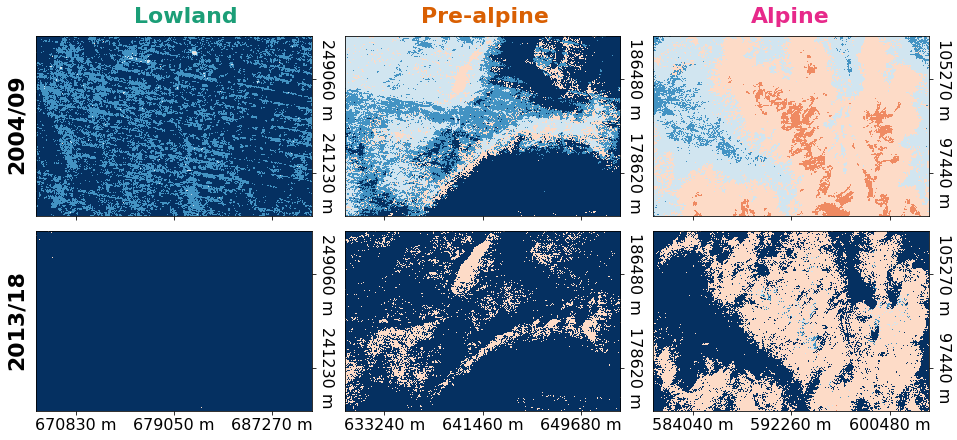

In [4]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import osr
import math
import numpy as np
from osgeo import gdal

%matplotlib inline

def save_geotiff(ds,fname):
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None


# function to read in a data cube from a geo tiff file
def geotiff_to_datacube(ds):
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function


def datacube_to_geotiff(data_cube,geotransform,epsg):
    
    n_rows, n_cols, n_bands = data_cube.shape
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    for i_band in range(n_bands):
        ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    return ds

def plot_model(ax,ds,colors,show_xlabels=True,show_ylabels=True):
    
    
    model, geotransform, epsg = geotiff_to_datacube(ds)
    
    xyz_shape = (model.shape[0], model.shape[1], 1)
    
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,5), cmap.N)
    
    im = ax.imshow(model[:,:,0], cmap=cmap, norm=norm)
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform

    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    # end of function
    

""" //////////////////////// main //////////////////////// """


# run for different region of interests 
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
years2004 = [2007,2006,2007]
years2013 = [2016,2015,2016]
validation_type = 'qualitative'


# path to data
paths = [f'D:/thesis/scripts/data/synthetic_images/{roi}/' for roi in rois]

fontsize_title = 22
fontsize = 16

classes = [
    '[n==0] Perpetual snow or ice',
    '[n<12 or invalid] Median',
    '[12<=n<24] Harmonic fit k=1',
    '[24<=n<36] Harmonic fit k=2',
    '[36<=n] Harmonic fit k=3'
]

hex_colors = [
    '#ef8a62',
    "#fddbc7",
    "#d1e5f0",
    "#4393c3",
    "#053061"
]



fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.05, wspace=0.12)
axs = axs.ravel()

for iroi, roi in enumerate(rois):
    ds2004 = gdal.Open(f'{paths[iroi]}model_{roi}_{years2004[iroi]}.tif')
    ds2013 = gdal.Open(f'{paths[iroi]}model_{roi}_{years2013[iroi]}.tif')
    im = plot_model(axs[iroi],ds2004,hex_colors,False)
    im = plot_model(axs[iroi+len(rois)],ds2013,hex_colors)

"""
divider = make_axes_locatable(axs[3])
cax = divider.new_horizontal(size="5%", pad=4, pack_start=False)
#fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

cbar = fig.colorbar(im,cax=axs[3], orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)
"""
fig.text(0.255, 0.9, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.9, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.9, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')
fig.text(0.1, 0.7, '2004/09', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.1, 0.31, '2013/18', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'models.png', dpi=300, bbox_inches = "tight")

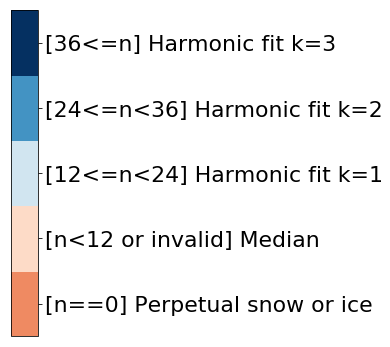

In [61]:

fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k', sharex=True) #sharey=True
plt.rcParams.update({'font.size': 22})


divider = make_axes_locatable(axs)
cax = divider.new_horizontal(size="5%", pad=5.8, pack_start=False)
# fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

cbar = fig.colorbar(im,cax=axs, orientation="vertical", ticks=np.linspace(0,4,5))
cbar.ax.set_yticklabels(classes)

plt.savefig(f'models_legend.png', dpi=300, bbox_inches = "tight")

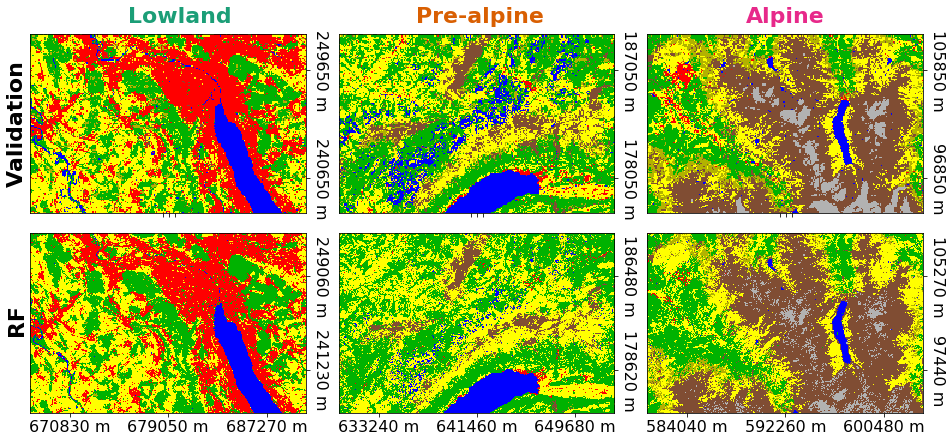

In [6]:

classes = ['Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
hex_colors = ["#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']

def plot_classification(ax,ds,show_xlabels=True,show_ylabels=True):
    

    cmap = mpl.colors.ListedColormap(hex_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
    
    
    classification, geotransform, epsg = geotiff_to_datacube(ds)
    
    xyz_shape = (classification.shape[0], classification.shape[1], 1)
    
    im = ax.imshow(classification[:,:,0], cmap=cmap, norm=norm)
    
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks]
    x_labels = [f'{x_start+x_res*i:.0f} m' for i in x_ticks] if show_xlabels==True else []
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    return im
    
    # end of plot roi function
    
    
# run for different region of interests 

classifier = 'rf'
rois = ['roi1','roi2','roi3']
roi_names = ['Lowland','Pre-alpine','Alpine']
oa_rf = [81.5,68.5,72.0]
kappa_rf = [73.9,53.6,61.5]
oa_nn = [77.4,62.1,67.0]
years2004 = [2007,2006,2007]
years2013 = [2016,2015,2016]
validation_type = 'qualitative'


# path to data
paths_AS = [f'D:/thesis/scripts/data/arealstatistik/{roi}' for roi in rois]
paths_class = [f'D:/thesis/scripts/data/classification/{roi}' for roi in rois]

fontsize_title = 22
fontsize = 16


fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k') #sharey=True
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.1, wspace=0.12)
axs = axs.ravel()

for i, (roi, name, pathAS, pathClass) in enumerate(zip(rois, roi_names, paths_AS, paths_class)):
    # arealstatistik reference
    dsAS = gdal.Open(f'{pathAS}/{roi}_raster.tif')
    im = plot_classification(axs[i],dsAS,False)
    
    if classifier == 'rf':
        dsRF = gdal.Open(f'{pathClass}/rf_{roi}.tif')
        im = plot_classification(axs[i+3],dsRF)
    elif classifier == 'nn':
        dsNN = gdal.Open(f'{pathClass}/nn_{roi}.tif')
        im = plot_classification(axs[i+3],dsNN,show_ylabels=True)
    
fig.text(0.255, 0.9, roi_names[0], ha='center',fontweight='bold',fontsize=fontsize_title,color='#1b9e77')
fig.text(0.515, 0.9, roi_names[1], ha='center',fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.78, 0.9, roi_names[2], ha='center',fontweight='bold',fontsize=fontsize_title,color='#e7298a')

fig.text(0.105, 0.7, 'Validation', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
fig.text(0.105, 0.31, classifier.upper(), va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'classification_{classifier}.png', dpi=300, bbox_inches = "tight")

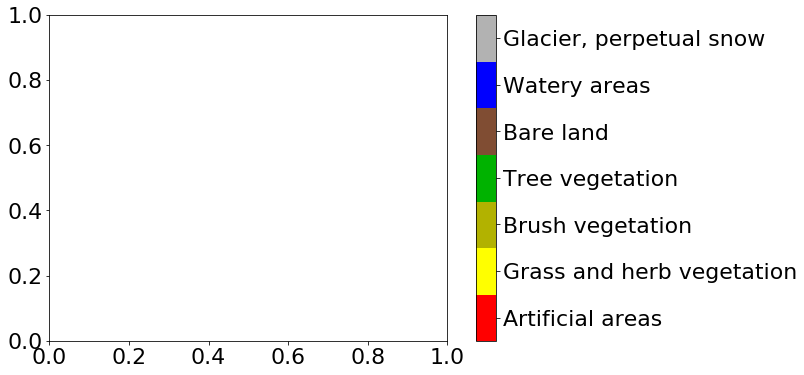

In [67]:




        
    # plot map
fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k', sharex=True) #sharey=True
plt.rcParams.update({'font.size': 22})

divider = make_axes_locatable(axs)
cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
cbar.ax.set_yticklabels(classes)
plt.savefig(f'classification_legend.png', dpi=300, bbox_inches = "tight")
plt.show()


In [38]:
a = f'test'

a.upper()

'TEST'